In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F

In [4]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data

In [5]:
#transform
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        lambda x: x>0.5,
        lambda x: x.float(),
    ])

In [6]:
# dataset loading
bsize = 100
train_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=True, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=False, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)

In [7]:
# hyperparameters
N = 5
k = 2
tau = 1.

In [8]:
# TODO: UPDATE TO BINARY GUMBEL (REFER TO L0-REG PAPER)
# gumbel-softmax
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    return -Variable(torch.log(-torch.log(U + eps) + eps))

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y

In [9]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 128)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        l = self.relu(self.fc2(h1))
        return l

In [10]:
class Tunnel(nn.Module):
    def __init__(self):
        super(Tunnel, self).__init__()
        self.fc1 = nn.Linear(128, 128)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        l = self.relu(self.fc1(x))
        return l

In [11]:
class Output(nn.Module):
    def __init__(self):
        super(Output, self).__init__()
        self.fc1 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        l = h1.view(-1,2)
        return l

In [12]:
class Gate(nn.Module):
    def __init__(self):
        super(Gate, self).__init__()
        self.fc1 = nn.Linear(1, 128)
        
    def forward(self, x):
        return F.sigmoid(self.fc1(x))

In [13]:
def prob(outputs):
    outputs = [F.softmax(out, dim=-1) for out in outputs]
    return torch.cat(outputs, dim=1).view(-1, N, k)

def sample(l):
    gs = gumbel_softmax(l, tau)
    return gs.narrow(1,0,1)

# def signal(outputs):
#     outputs = [sample(out).narrow(1,0,1) for out in outputs]
#     return torch.cat(outputs, dim=1)
    

In [14]:
class Decoder(nn.Module):  
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(N, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)      
        self.fc4 = nn.Linear(512, 784)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        h3 = self.relu(self.fc3(h2))
        h4 = self.fc4(h3)
        o = h4.view(-1,784)
        return F.sigmoid(o)

In [15]:
E = Encoder()
D = Decoder()
O0 = Output()
Os = [Output() for _ in range(N-1)]
Ts = [Tunnel() for _ in range(N-1)]
T1s = [Tunnel() for _ in range(N-1)]
Gs = [Gate() for _ in range(N-1)]

In [16]:
from itertools import product
    
log_two_pow_n = Variable(torch.Tensor([2**N]).log(), requires_grad=False)
# TODO cuda it

def get_dependent_prior_loss(x):
    acc = Variable(torch.zeros(2**N))
    acc_i = 0
    for _path in product(range(2), repeat=N):
        path = Variable(torch.Tensor(_path), requires_grad=False)
        sofar = E(x)
        outputs = [O0(sofar)]

        for n in range(len(Ts)):
            sofar = Ts[n](sofar)*Gs[n](path[n]) # Kind of doing "teacher forcing"
            outputs.append(Os[n](sofar))

        q = prob(outputs)

        _idx = path.data
        select_mat = Variable(torch.stack([1-_idx, _idx]).t(), requires_grad=False)
        select_mat = select_mat.expand(torch.Size([x.shape[0]]) + select_mat.shape)
        probs = q.mul(select_mat).sum(-1) # shape (batch x N)
        log_q = (probs+1e-20).log().sum(-1) # shape (batch)
        kl_term = log_q.exp().mul(log_two_pow_n + log_q) # shape (batch)
        kl_term = kl_term.mean() # shape (1) - take sum over minibatch

        acc[acc_i] = kl_term
        acc_i += 1

    return acc.sum()

In [17]:
# TESTING
# Hacky! Getting a data point.
for batch_idx, (data, _) in enumerate(train_loader):
    data = Variable(data)
    x = data.view(-1,784)
    x = x[0:4]
    break
    
get_dependent_prior_loss(x)

Variable containing:
1.00000e-03 *
  1.8357
[torch.FloatTensor of size 1]

In [18]:
# TODO
# objective
def loss_function(recon_x, x, q):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=True) # TODO eddie: changed from size_average=False
    
    # Assuming independent latent
#     KLD = torch.sum(q*(torch.log(q+1E-20)-np.log(1/k)))

    # Assuming dependent latent
    KLD = get_dependent_prior_loss(x)
    
    return BCE, KLD

In [19]:
params = [
    {'params':E.parameters()},
    {'params':D.parameters()},
    {'params':O0.parameters()},
] + [{'params':o.parameters()} for o in Os] \
  + [{'params':t.parameters()} for t in Ts] + [{'params': g.parameters()} for g in Gs]
optimizer = optim.Adam(params, lr=1e-4)

In [20]:
%%time

# training
epochs = 10

for epoch in range(epochs):
    train_bce_loss = 0
    train_kld_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        x = data.view(-1,784)
        optimizer.zero_grad()
        sofar = E(x)
        outputs = [O0(sofar)]
        samples = [sample(outputs[-1])]
        for n in range(len(Ts)):
            sofar = Ts[n](sofar)*Gs[n](samples[-1])
            outputs.append(Os[n](sofar))
            samples.append(sample(outputs[-1]))
        bits = torch.cat(samples, dim=1)
        q = prob(outputs)
        recon_x = D(bits)
        BCE, KLD = loss_function(recon_x, x, q)
        loss = BCE + KLD
        loss.backward()
        optimizer.step()
        
        train_bce_loss += BCE.data[0]
        train_kld_loss += KLD.data[0]
        
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tBCE loss: {:.6f}\tKLD loss: {:.6f}'.format(
                epoch+1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                BCE.data[0] / len(data),
                KLD.data[0] / len(data)))
            
    print('====> Epoch: {} Average BCE loss: {:.4f}, Average KLD loss: {:.4f}'.format(
          epoch+1, train_bce_loss / len(train_loader.dataset), train_kld_loss / len(train_loader.dataset)))

Train Epoch: 1 [0/60000 (0%)]	BCE loss: 0.006934	KLD loss: 0.000019
Train Epoch: 1 [20000/60000 (33%)]	BCE loss: 0.002698	KLD loss: 0.000000
Train Epoch: 1 [40000/60000 (67%)]	BCE loss: 0.002706	KLD loss: 0.000000
====> Epoch: 1 Average BCE loss: 0.0031, Average KLD loss: 0.0000
Train Epoch: 2 [0/60000 (0%)]	BCE loss: 0.002599	KLD loss: 0.000000
Train Epoch: 2 [20000/60000 (33%)]	BCE loss: 0.002589	KLD loss: 0.000000
Train Epoch: 2 [40000/60000 (67%)]	BCE loss: 0.002606	KLD loss: 0.000000
====> Epoch: 2 Average BCE loss: 0.0026, Average KLD loss: 0.0000
Train Epoch: 3 [0/60000 (0%)]	BCE loss: 0.002565	KLD loss: 0.000000
Train Epoch: 3 [20000/60000 (33%)]	BCE loss: 0.002714	KLD loss: 0.000000
Train Epoch: 3 [40000/60000 (67%)]	BCE loss: 0.002722	KLD loss: 0.000000
====> Epoch: 3 Average BCE loss: 0.0026, Average KLD loss: 0.0000
Train Epoch: 4 [0/60000 (0%)]	BCE loss: 0.002670	KLD loss: 0.000000
Train Epoch: 4 [20000/60000 (33%)]	BCE loss: 0.002692	KLD loss: 0.000000
Train Epoch: 4 [400

In [21]:
q

Variable containing:
( 0 ,.,.) = 
  0.5000  0.5000
  0.5000  0.5000
  0.5000  0.5000
  0.5000  0.5000
  0.5000  0.5000

( 1 ,.,.) = 
  0.5000  0.5000
  0.5000  0.5000
  0.5000  0.5000
  0.5000  0.5000
  0.5000  0.5000

( 2 ,.,.) = 
  0.5000  0.5000
  0.5000  0.5000
  0.5000  0.5000
  0.5000  0.5000
  0.5000  0.5000
... 

(97 ,.,.) = 
  0.5000  0.5000
  0.5000  0.5000
  0.5000  0.5000
  0.5000  0.5000
  0.5000  0.5000

(98 ,.,.) = 
  0.5000  0.5000
  0.5000  0.5000
  0.5000  0.5000
  0.5000  0.5000
  0.5000  0.5000

(99 ,.,.) = 
  0.5000  0.5000
  0.5000  0.5000
  0.5000  0.5000
  0.5000  0.5000
  0.5000  0.5000
[torch.FloatTensor of size 100x5x2]

In [22]:
bits

Variable containing:
    1     1     1     0     1
    0     1     0     0     0
    0     0     0     0     0
    1     0     1     1     0
    0     0     1     1     0
    0     1     0     0     0
    1     1     0     1     1
    1     0     0     0     0
    0     1     1     0     1
    1     1     1     1     0
    0     0     1     1     0
    1     0     1     1     0
    0     1     1     1     0
    0     0     1     0     1
    0     1     1     1     1
    1     0     1     0     1
    1     1     0     1     1
    0     1     1     1     1
    1     1     0     0     0
    0     1     1     1     1
    0     0     1     1     0
    0     1     0     1     1
    1     1     0     1     0
    0     0     0     1     0
    0     1     1     1     0
    0     1     0     1     1
    0     1     0     1     1
    0     0     1     0     1
    1     0     1     1     0
    0     1     1     0     1
    1     0     0     1     0
    1     0     0     0     0
    1     1     0  

In [23]:
test_set = dset.MNIST('data', train=False, download=True, transform=data_transforms)

In [24]:
# a = np.array([[0., 0., 0., 0.]])
# w = D.forward(Variable(torch.from_numpy(a).type(torch.FloatTensor)))
# plt.imshow(w.view(28,28).data.numpy())

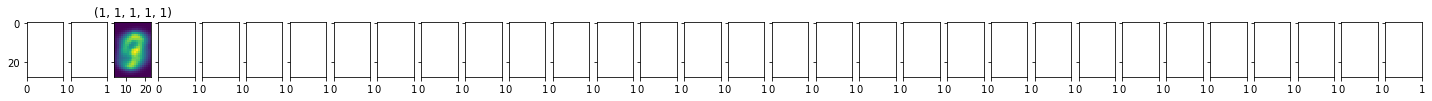

In [25]:
from itertools import product
f, axes = plt.subplots(1, 2**N, sharey=True, figsize=(25,1))
kk = 0
for path in product(range(2), repeat=N):
    w = D.forward(Variable(torch.Tensor(path).type(torch.FloatTensor)))
    ax = axes[k]
    ax.set_title(path)
    ax.imshow(w.view(28,28).data.numpy())
    kk += 1